# Convex trajectory optimisation
In this tutorial, we are going to describe standard methods for convex trajectory optimisation. We will briefly talk about integration schemes for solving Ordinary Differential Equations, but our main objective is to make sure you are familiar with the formulation of a Quadratic Program and the formulation of a trajectory optimisation problem. We will first consider a discrete collocation method, before discussing polynomial fitting and continuous formulation.

## Dynamics of a point mass system
We are first going to consider a simple example to define a few key notions.
Let us consider a 2D point $\mathbf{p} \in \mathbb{R}^2$ moving in a 0-gravity environment. Let us consider that the point is able to control its acceleration, such that the we define the control $\mathbf{u}$ as   $\mathbf{u} = \mathbf{\ddot{p}} \in \mathbb{R}^2$.
We define the state of the robot as $\mathbf{x} = [\mathbf{p}, \dot{\mathbf{p}}]^T$ where $\dot{p} \in \mathbb{R}^2$ is the velocity of the point.

The dynamics of the system are described under the generic form

\begin{equation}
\dot{\mathbf{x}}(t) = \mathbf{f}(\mathbf{x}(t), \mathbf{u}(t), t)
\end{equation}
where $t \in \mathbb{R}$ is the time variable and  $\mathbf{f}(\mathbf{x}, \mathbf{u}, t)$ represents the system dynamics.
This is the form of an Ordinary Differential Equation (ODE). 
### A simple way to solve an ODE: Forward Euler integration, a discretised approach
To solve this system numerically, we can discretise time into steps of size $\Delta t$. The forward Euler method approximates the state at the next time step as:
\begin{equation}
\mathbf{x}_{k+1} = \mathbf{x}_k + \Delta t \cdot \mathbf{f}(\mathbf{x}_k, \mathbf{u}_k)
\end{equation}
where:
 +  $\mathbf{x}_k$ is the state at time step $t_k$,
 + $\mathbf{u}_k$ is the control input at time step $t_k$,
 + $\Delta t$ is the time step size,
 + $\mathbf{f}(\mathbf{x}_k, \mathbf{u}_k)$ is the system dynamics evaluated at time $t_k$.

In our case $f$ is simply Newton's second law of motion, such 
that $\mathbf{f}(\mathbf{x}(t), \mathbf{u}(t), t) = [\dot{\mathbf{p}}, \ddot{\mathbf{p}}]^T$

\begin{equation}
\mathbf{x}_{k+1} = 
\begin{bmatrix}
\mathbf{p}_{k+1} \\
\dot{\mathbf{p}}_{k+1}
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{p}_k + \Delta t \cdot \dot{\mathbf{p}}_k \\
\dot{\mathbf{p}}_k + \Delta t \cdot \mathbf{u}_k
\end{bmatrix}
\end{equation}

With this recursive formulation, from an initial state $\mathbf{x}_0$ and given a series of control inputs, we can approximate a resulting trajectory:


In [1]:
import numpy as np

def integrate(x, u, dt):
    return [x[0] + dt * x[1], x[1] + dt * u]


def simulate(x_0, u_s, dt = 0.01):
    trajectory = [x_0]
    for u in u_s:
        trajectory = trajectory + [integrate(trajectory[-1], u, dt)]
    return trajectory


We can test the method and plot the resulting trajectory

100


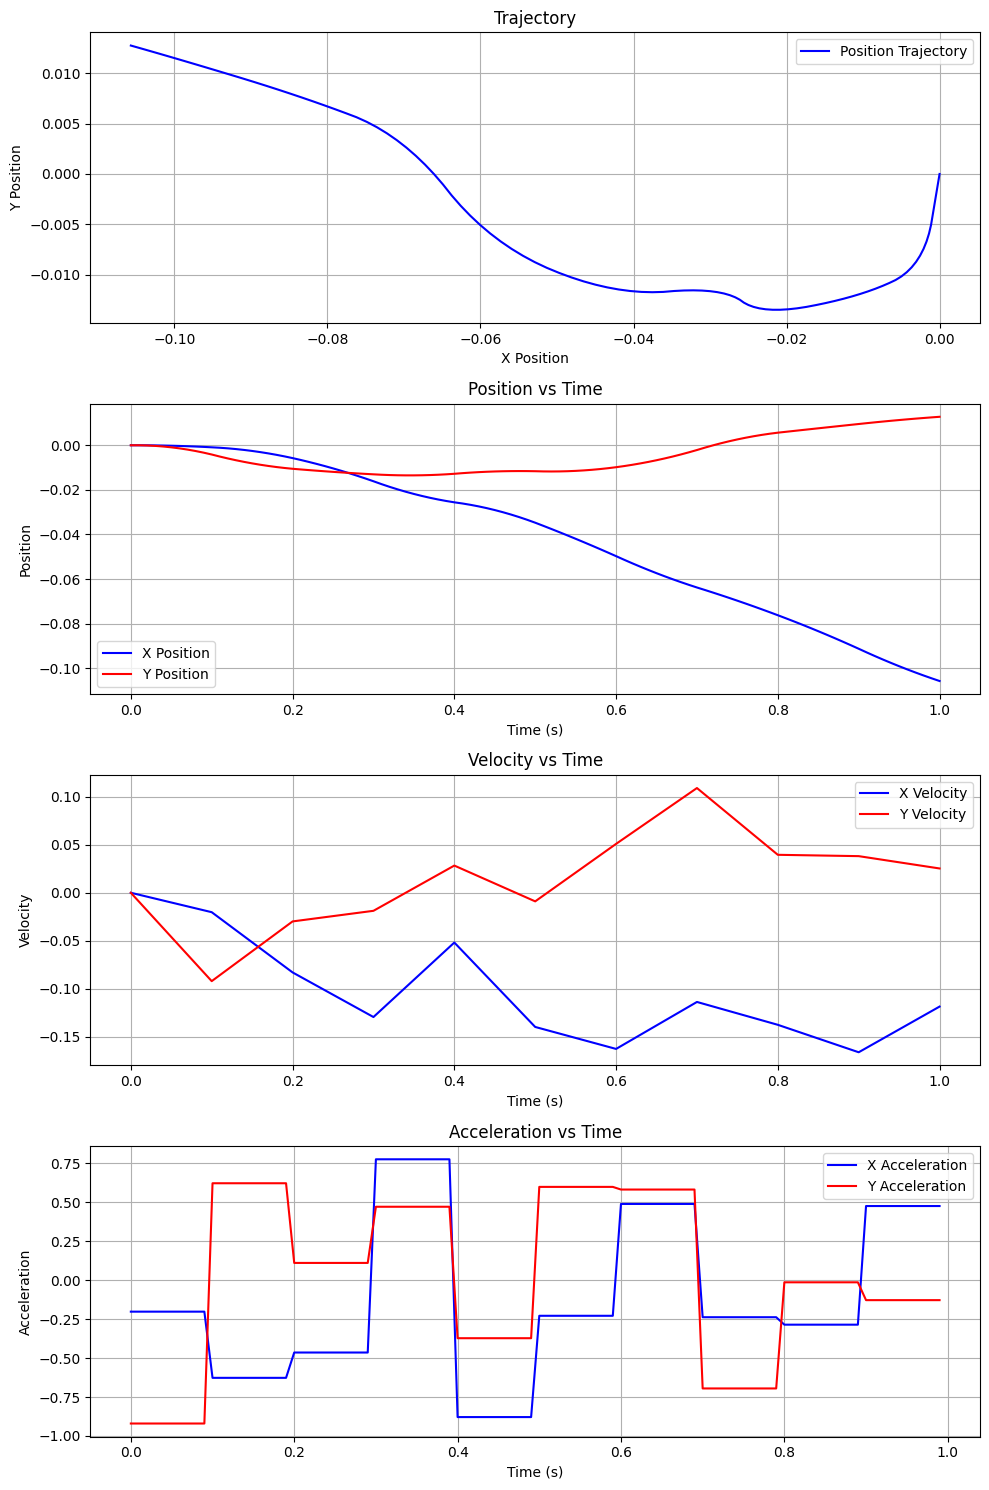

In [2]:
import matplotlib.pyplot as plt

def plot_trajectory(trajectory, u_s, dt=0.01):
    positions = np.array([x[0] for x in trajectory])
    velocities = np.array([x[1] for x in trajectory])
    accelerations = u_s

    # Create time array for plotting
    time = np.arange(0, len(trajectory) * dt, dt)

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(10, 15))

    # Plot trajectory
    axs[0].plot(positions[:, 0], positions[:, 1], label='Position Trajectory', color='b')
    axs[0].set_title('Trajectory')
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Y Position')
    axs[0].grid()
    axs[0].legend()
    
    # Plot Positions
    axs[1].plot(time, positions[:, 0], label='X Position', color='b')  # X Position
    axs[1].plot(time, positions[:, 1], label='Y Position', color='r')  # Y Position
    axs[1].set_title('Position vs Time')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Position')
    axs[1].grid()
    axs[1].legend()

    # Plot Velocities
    axs[2].plot(time, velocities[:, 0], label='X Velocity', color='b')  # X Velocity
    axs[2].plot(time, velocities[:, 1], label='Y Velocity', color='r')  # Y Velocity
    axs[2].set_title('Velocity vs Time')
    axs[2].set_xlabel('Time (s)')
    axs[2].set_ylabel('Velocity')
    axs[2].grid()
    axs[2].legend()

    # Plot Accelerations
    axs[3].plot(time[:-1], accelerations[:, 0], label='X Acceleration', color='b')  # X Acceleration
    axs[3].plot(time[:-1], accelerations[:, 1], label='Y Acceleration', color='r')  # Y Acceleration
    axs[3].set_title('Acceleration vs Time')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Acceleration')
    axs[3].grid()
    axs[3].legend()

    plt.tight_layout()
    plt.show()

N = 100
x_0 = [np.zeros(2),np.zeros(2)]
#follow a random direction for N/10 iterations then change
controls = np.random.uniform(-1, 1, (int(N/10), 2))
u_s = np.repeat(controls, repeats=10, axis=0)
print(len(u_s))
trajectory = simulate(x_0, u_s)
plot_trajectory(trajectory, u_s)

Let us now consider the following problem. Given a target $\mathbf{x}_goal$ and an initial state $\mathbf{x}_0$, we want to compute a trajectory that successfully reaches $\mathbf{x}_{goal}$ after a fixed duration $T = 10s$.

We can write this as a feasibility problem under the dynamics constraints

<center><img src="./tp6/feasibility.png"/ width="340"></center>

which gives, once discretised:


<center><img src="./tp6/feasdisc.png"/ width="440"></center>

We need to write this in matrix form to properly set our problem. Let's take a closer look at the equations:

given $\mathbf{x}_0 = [\mathbf{p}_0, \dot{\mathbf{p}}_0]^T$ and $\mathbf{u}_0$, we know that 
we have $\mathbf{x}_1= [\mathbf{p}_0 + \Delta t \dot{\mathbf{p}}_0,  \dot{\mathbf{p}}_0 + \Delta t \mathbf{u}_0] $.

Likewise 

\begin{aligned}
\mathbf{x}_2  & = &   [\mathbf{p}_1 + \Delta t \dot{\mathbf{p}}_1,  \dot{\mathbf{p}}_1 + \Delta t \mathbf{u}_1]^T \\
     &     = &  [\mathbf{p}_0 +  \Delta t \dot{\mathbf{p}}_0 + \Delta t (\dot{\mathbf{p}}_0 + \Delta t \mathbf{u}_0),  \dot{\mathbf{p}}_0 + \Delta t \mathbf{u}_0 + \Delta t \mathbf{u}_1]^T
\end{aligned}

We can see here that at each recurrence step we will multiply the previous values found by $\Delta t$, which is likely to lead to numerical errors, especially is $\Delta t < 1$. We propose to simply scale the problem variables such $\Delta t = 1$. In our case for instance, we will just consider 1 ms intervals, and adapt the potential resulting constraints accordingly (later).

This also greatly simplifies the recurrence formula, which simply becomes, for the final position:
\begin{aligned}
\mathbf{p}_k = \mathbf{p}_0 + k * \dot{\mathbf{p}_0} + \sum_{i=0}^{k-2} (k-i-1) * \mathbf{u}_i
\end{aligned}

This gives us two constraints to satisfy, which are:
\begin{aligned}
\mathbf{p}_{goal} & = & \mathbf{p}_{N-1} & =  \mathbf{p}_0 + (N-1) * \dot{\mathbf{p}}_0 + \sum_{i=0}^{N-3} (N-i -2) * \mathbf{u}_i & \\
\dot{\mathbf{p}}_{goal} & = & \dot{\mathbf{p}}_{N-1} & =   \dot{\mathbf{p}_{0}} +  \sum_{i=0}^{N-2}  \mathbf{u}_i& 
\end{aligned}

## Our first Linear Program

The generic form of a linearly constrained problem is:

<center><img src="./tp6/LP.png"/ width="150"></center>

If $\mathbf{c} \in \mathbb{R}^n$, then the matrices $\mathbf{A}$ and $\mathbf{E}$ have $n$ columns.
The number of rows, on the other end, depends on the number of constraints. 

Because we apply $N-1$ controls, we need $n =2N - 2$ variables to represent our control variables. The reason for this is that we work in 2 dimensions. 

In our case, we don't have any inequality constraints at this point, and two equality contraints. However this constraint are 2D as $\mathbf{p}_{goal} \in \mathbb{R}^2$  As a result $\mathbf{E} \in \mathbb{R}^{4*n}$ and $\mathbf{e} \in \mathbb{R^4}$.

We'll write $\mathbf{c} = [u_0, \dots, u_{n-2} ]$. We will also add bounds on acceleration to prevent simply "teleporting" to the goal.


This problem is called a feasibility problem as we are not considering an objective function at this point, and are only looking for a feasible solution. Let us code and solve the problem using linprog. before that let's change our plotting function to plot the target position as well.



In [3]:
def plot_trajectory(trajectory, u_s, p_goal, dt=1):
    positions = np.array([x[0] for x in trajectory])
    velocities = np.array([x[1] for x in trajectory])
    accelerations = np.array(u_s)

    # Create time array for plotting
    time = np.arange(0, len(trajectory) * dt, dt)

    # Plotting
    fig, axs = plt.subplots(4, 1, figsize=(10, 15))

    # Plot trajectory
    axs[0].plot(positions[:, 0], positions[:, 1], label='Position Trajectory', color='b')
    axs[0].scatter(p_goal[0], p_goal[1], color='r', label='Goal', zorder=5)  # Plot the goal point   
    axs[0].set_title('Trajectory')
    axs[0].set_xlabel('X Position')
    axs[0].set_ylabel('Y Position')
    axs[0].grid()
    axs[0].legend()
    
    # Plot Positions
    axs[1].plot(time, positions[:, 0], label='X Position', color='b')  # X Position
    axs[1].plot(time, positions[:, 1], label='Y Position', color='r')  # Y Position
    axs[1].set_title('Position vs Time')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('Position')
    axs[1].grid()
    axs[1].legend()

    # Plot Velocities
    axs[2].plot(time, velocities[:, 0], label='X Velocity', color='b')  # X Velocity
    axs[2].plot(time, velocities[:, 1], label='Y Velocity', color='r')  # Y Velocity
    axs[2].set_title('Velocity vs Time')
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('Velocity')
    axs[2].grid()
    axs[2].legend()

    # Plot Accelerations
    axs[3].plot(time[:-1], accelerations[:, 0], label='X Acceleration', color='b')  # X Acceleration
    axs[3].plot(time[:-1], accelerations[:, 1], label='Y Acceleration', color='r')  # Y Acceleration
    axs[3].set_title('Acceleration vs Time')
    axs[3].set_xlabel('Time (ms)')
    axs[3].set_ylabel('Acceleration')
    axs[3].grid()
    axs[3].legend()

    plt.tight_layout()
    plt.show()

In [4]:
import numpy as np
from scipy.optimize import linprog

def feasibility(x_0,x_goal,N):
    p_0 = x_0[0]  # Initial position
    d_p0 = x_0[1]  # Initial velocity
    p_goal = x_goal[0]  # Goal position
    dp_goal = x_goal[1]  # Goal velocity

    n = 2 * (N - 1)  # Number of control inputs (2 for each time step, x and y axes)
    l = np.zeros(n) #we need to specify an empty cost in the API
    E = np.zeros((4,n))
    e = np.zeros(4)
    e[:2] = p_goal - p_0[:] - (N-1) * d_p0
    e[2:] = dp_goal - d_p0[:]
    x_bounds = [(-0.02, 0.02) for _ in range(n)] #arbitrary bounds on maximum acceleration

    for i in range(N-3):
        coeff_ui = N-i-2
        E[0,i*2]   = coeff_ui # position constraint on x 
        E[1,i*2+1] = coeff_ui # position constraint on y 
        E[2,i*2]   = 1 # velocity constraint on x 
        E[3,i*2+1] = 1 # velocity constraint on y
    i = N-2
    E[2,i*2]   = 1 # velocity constraint on x 
    E[3,i*2+1] = 1 # velocity constraint on y
    
    return linprog(l, A_eq=E, b_eq=e, bounds=x_bounds )

    
N = 100
x_0 = [np.zeros(2),np.zeros(2)]
x_goal = [np.random.uniform(-1, 1, 2) for _ in range(2)]

print("target position ", x_goal[0])
print("target position ", x_goal[1])
result = feasibility(x_0,x_goal,N)
if result.success:
    print("Optimal value:", result.fun)
    controls = [ result.x[i*2:i*2+2] for i in range (N-1)]
    trajectory = simulate(x_0, controls, dt = 1)
    plot_trajectory(trajectory, controls, x_goal[0])
else:
    print("Optimization failed. This problem is unfeasible, run again the cell:", result.message)

target position  [-0.06223606  0.8590666 ]
target position  [ 0.86970747 -0.40266538]
Optimization failed. This problem is unfeasible, run again the cell: The problem is infeasible. (HiGHS Status 8: model_status is Infeasible; primal_status is At lower/fixed bound)


This works, but our trajectories are not looking that good.
Let's add a cost function that, for instance, minimise the integral of the acceleration squared:

$l = \sum_{i=0}^{N-2} \mathbf{c}_i^2$

This is easily written in matrix form as 

$l(\mathbf{c}) = \mathbf{c}^T \mathbf{H} \mathbf{c}$, where $\mathbf{H}$ is the identity matrix.  This cost function is convex, and thus our minimisation problem fits the form of a convex Quadratic Program (QP), which can be solved easily.

We can easily add this cost to our problem by switching from linprog to quadprog.
The API of quadprog is not completely intuitive, so I have added a helper function that more directly corresponds to the matrices we have been working with. Additionally, quadprog does not allow to directly specify bounds on varibles, which means we are going to need to add inequality constraints to satisfy our bounds.



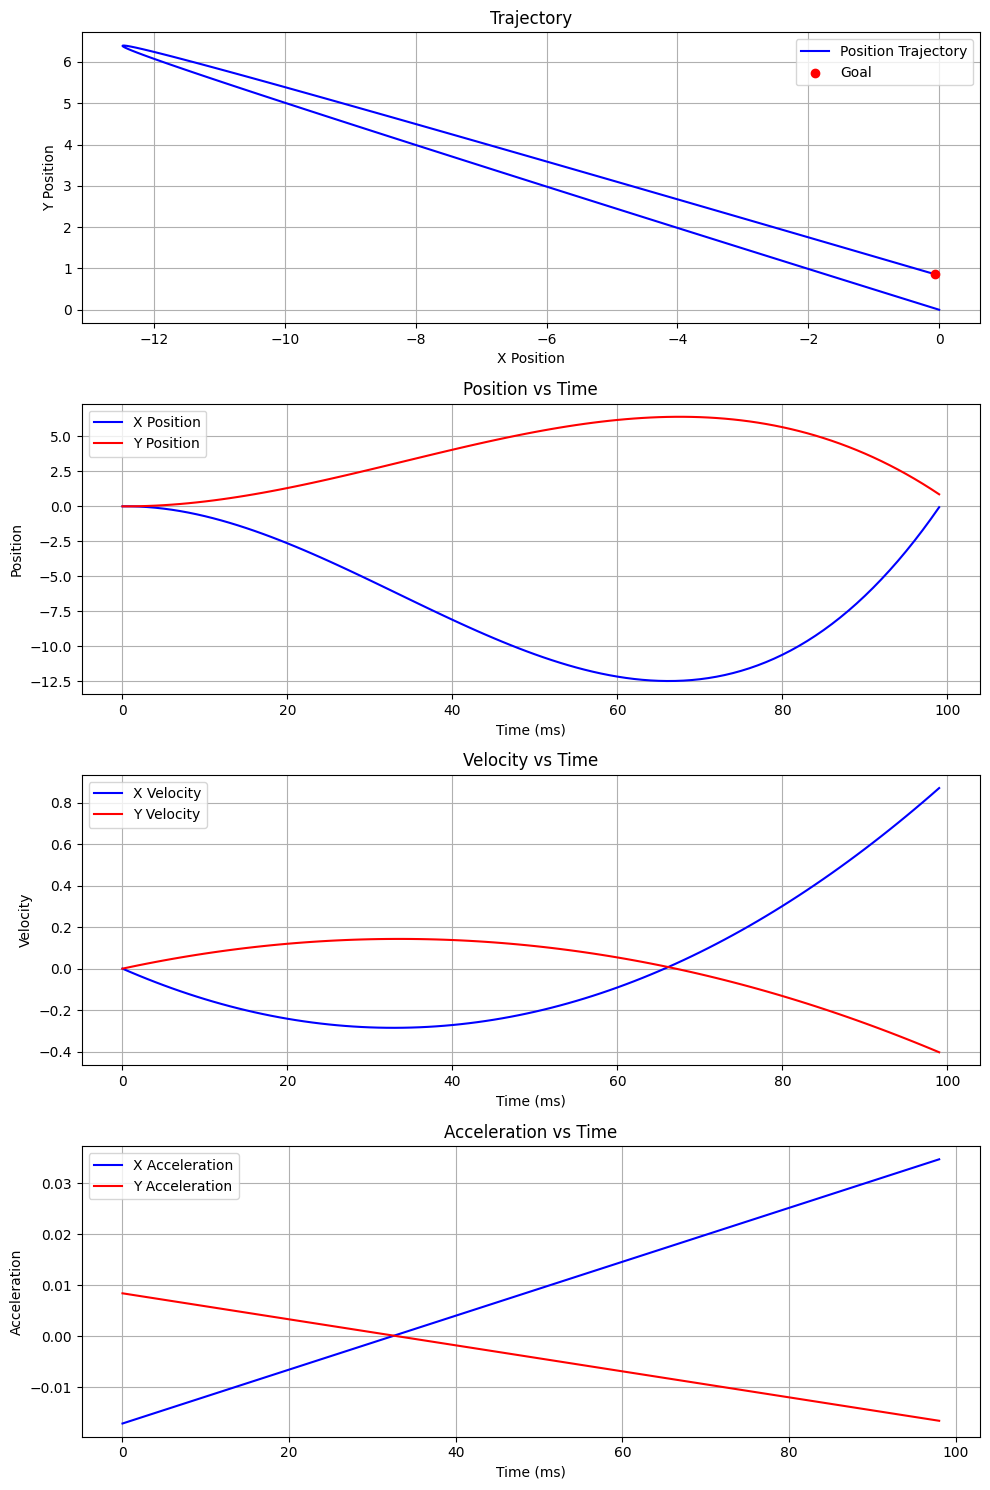

In [5]:
import quadprog


def quadprog_solve_qp(H, q, G=None, h=None, C=None, d=None, verbose=False):
    """
    min (1/2)x' P x + q' x
    subject to  G x <= h
    subject to  C x  = d
    """
    qp_G = 0.5 * (H + H.T)  # make sure P is symmetric
    qp_a = -q
    qp_C = None
    qp_b = None
    meq = 0
    if C is not None:
        if G is not None:
            qp_C = -np.vstack([C, G]).T
            qp_b = -np.hstack([d, h])
        else:
            qp_C = -C.transpose()
            qp_b = -d
        meq = C.shape[0]
    elif G is not None:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    if verbose:
        return res
    return res[0]




def solve_min_acceleration(x_0, x_goal, N):
    p_0 = x_0[0]  # Initial position
    d_p0 = x_0[1]  # Initial velocity
    p_goal = x_goal[0]  # Goal position
    dp_goal = x_goal[1]  # Goal velocity

    n = 2 * (N - 1)  # Number of control inputs (2 for each time step, x and y axes) 
    # Hessian matrix (Identity matrix, since we are minimizing squared control inputs)
    H = np.eye(n)
    # Linear term (we don't have any linear cost, so it's all zeros)
    l = np.zeros(n)
    E = np.zeros((4,n))
    e = np.zeros(4)
    e[:2] = p_goal - p_0[:] - (N-1) * d_p0
    e[2:] = dp_goal - d_p0[:]
    x_bounds = [(-1, 1) for _ in range(n)]

    for i in range(N-1):
        coeff_ui = N-i-2
        E[0,i*2]   = coeff_ui # position constraint on x 
        E[1,i*2+1] = coeff_ui # position constraint on y 
        E[2,i*2]   = 1 # velocity constraint on x 
        E[3,i*2+1] = 1 # velocity constraint on y

    # Boundaries on the control inputs (these should be inequality constraints, but we'll set wide bounds)
    bounds = 0.1  # Bound on the control inputs
    lower_bounds = -bounds * np.ones(n)
    upper_bounds = bounds * np.ones(n)

    # Solve using quadprog (quadprog solves inequality constraints, so we need to use general inequality format)
    # Here we set the bounds as inequality constraints: A c <= b
    A = np.vstack([-np.eye(n), np.eye(n)])
    b = np.hstack([-lower_bounds, upper_bounds])

    # Solve the quadratic program
    return quadprog_solve_qp(H, l, A, b, E, e)

# Example usage
N = 100
x_0 = [np.zeros(2), np.zeros(2)]  # Starting at (0,0) with zero velocity
#x_goal = [np.random.uniform(-1, 1, 2), np.random.uniform(-0.1, 0.1, 2)]  # Random goal

result = solve_min_acceleration(x_0, x_goal, N)
controls = [ result[i*2:i*2+2] for i in range (N-1)]
trajectory = simulate(x_0, controls, dt=1)
plot_trajectory(trajectory, controls, x_goal[0])

Much better !

## Additional exercices

 + Transform the equality constraint into a cost to solve at best the problem when it is unfeasible
 + Try to write the problem such that the objective is reached as soon as possible. In this case assume that the final velocity is always 0, it will make your life easier. You have several options for this:
   +  The first one is add a higher cost to controls that happen towards the end of the motion. This should allow you to approximate the solution.
     +  Another other option is to include  $\Delta t$ as a variable (this is hard). You can keep the same number of variables but aim at minimising $\Delta t$. This involves rewriting the equations. Furthermore, your problem will no longer be linear so a non-linear solver will be required. You will also see that this is numerically unstable.


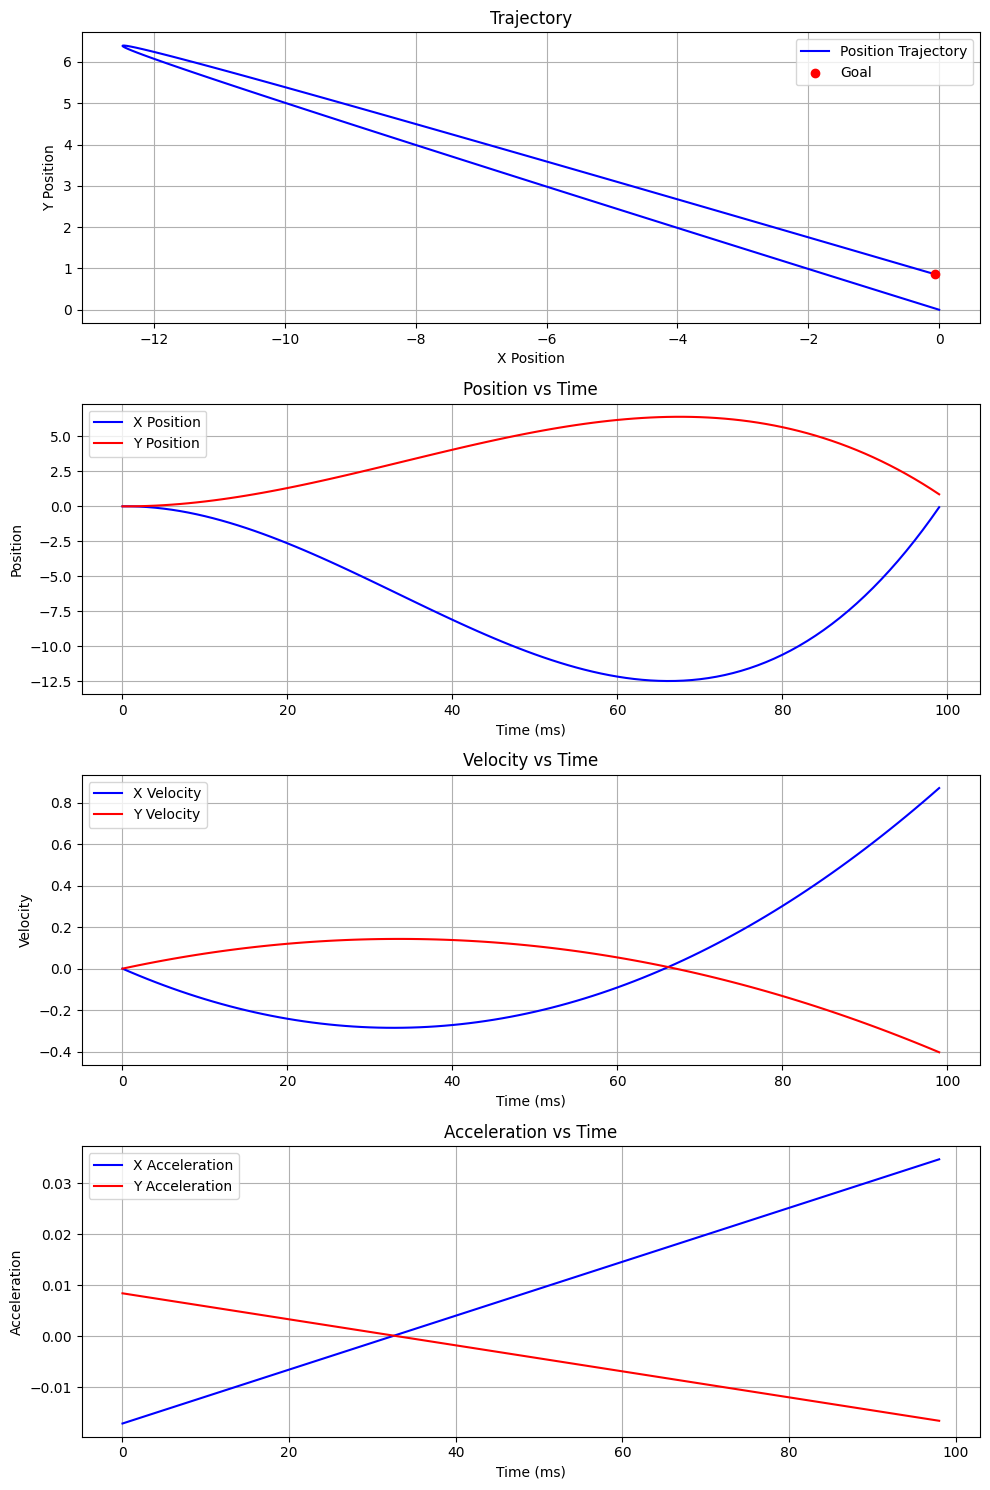

In [6]:
import quadprog


def quadprog_solve_qp(H, q, G=None, h=None, C=None, d=None, verbose=False):
    """
    min (1/2)x' P x + q' x
    subject to  G x <= h
    subject to  C x  = d
    """
    qp_G = 0.5 * (H + H.T)  # make sure P is symmetric
    qp_a = -q
    qp_C = None
    qp_b = None
    meq = 0
    if C is not None:
        if G is not None:
            qp_C = -np.vstack([C, G]).T
            qp_b = -np.hstack([d, h])
        else:
            qp_C = -C.transpose()
            qp_b = -d
        meq = C.shape[0]
    elif G is not None:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
    res = quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)
    if verbose:
        return res
    return res[0]




def solve_min_acceleration(x_0, x_goal, N):
    p_0 = x_0[0]  # Initial position
    d_p0 = x_0[1]  # Initial velocity
    p_goal = x_goal[0]  # Goal position
    dp_goal = x_goal[1]  # Goal velocity

    n = 2 * (N - 1)  # Number of control inputs (2 for each time step, x and y axes) 
    # Hessian matrix (Identity matrix, since we are minimizing squared control inputs)
    H = np.eye(n)
    # Linear term (we don't have any linear cost, so it's all zeros)
    l = np.zeros(n)
    E = np.zeros((4,n))
    e = np.zeros(4)
    e[:2] = p_goal - p_0[:] - (N-1) * d_p0
    e[2:] = dp_goal - d_p0[:]
    x_bounds = [(-1, 1) for _ in range(n)]

    for i in range(N-1):
        coeff_ui = N-i-2
        E[0,i*2]   = coeff_ui # position constraint on x 
        E[1,i*2+1] = coeff_ui # position constraint on y 
        E[2,i*2]   = 1 # velocity constraint on x 
        E[3,i*2+1] = 1 # velocity constraint on y

    # Boundaries on the control inputs (these should be inequality constraints, but we'll set wide bounds)
    bounds = 0.1  # Bound on the control inputs
    lower_bounds = -bounds * np.ones(n)
    upper_bounds = bounds * np.ones(n)

    # Solve using quadprog (quadprog solves inequality constraints, so we need to use general inequality format)
    # Here we set the bounds as inequality constraints: A c <= b
    A = np.vstack([-np.eye(n), np.eye(n)])
    b = np.hstack([-lower_bounds, upper_bounds])

    # Solve the quadratic program
    return quadprog_solve_qp(H, l, A, b, E, e)

# Example usage
N = 100
x_0 = [np.zeros(2), np.zeros(2)]  # Starting at (0,0) with zero velocity
#x_goal = [np.random.uniform(-1, 1, 2), np.random.uniform(-0.1, 0.1, 2)]  # Random goal

result = solve_min_acceleration(x_0, x_goal, N)
controls = [ result[i*2:i*2+2] for i in range (N-1)]
trajectory = simulate(x_0, controls, dt=1)
plot_trajectory(trajectory, controls, x_goal[0])